In [1]:
import numpy as np
import healpy as hp

In [2]:
n_side = 512

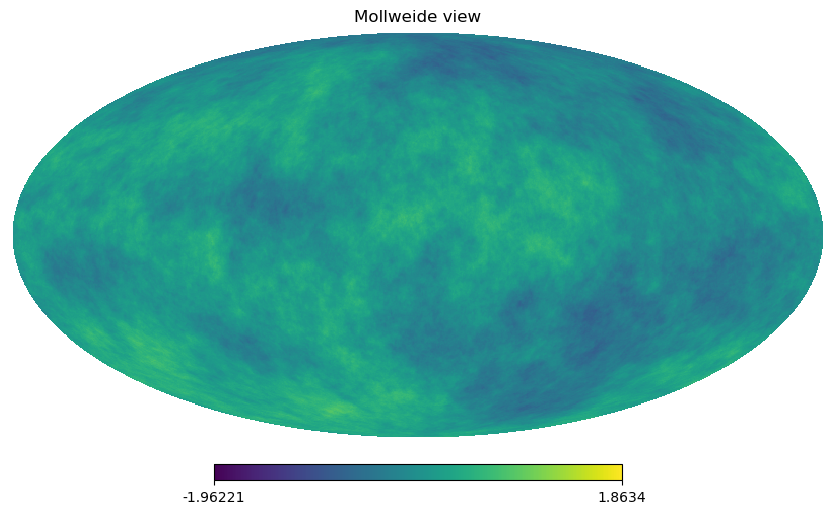

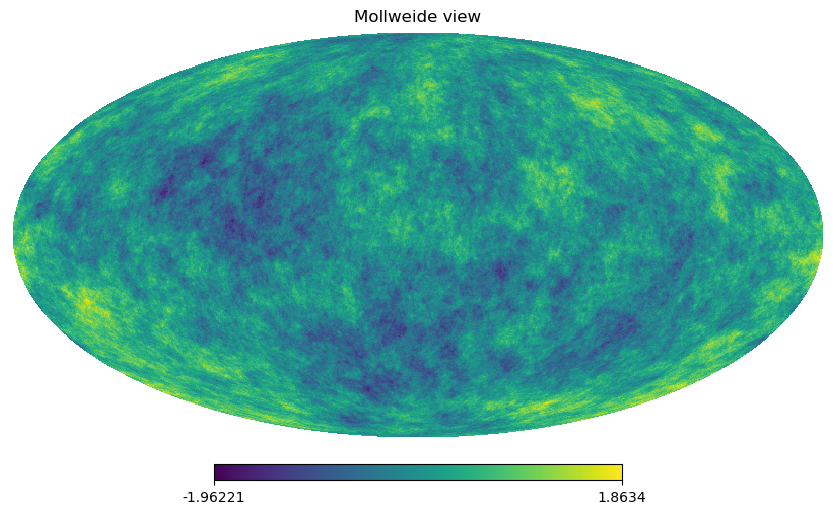

In [3]:
np.random.seed(11)

Cl_1 = np.arange(1, 1500)**-3.
Cl_2 = np.arange(1, 1500)**-2.5

map_1 = hp.synfast(cls=Cl_1, nside=n_side)
map_1 -= np.mean(map_1)
map_2 = hp.synfast(cls=Cl_2, nside=n_side)
map_2 -= np.mean(map_2)

z_min = np.min([map_1, map_2])
z_max = np.max([map_1, map_2])

hp.mollview(map_1, min=z_min, max=z_max)
hp.mollview(map_2, min=z_min, max=z_max)

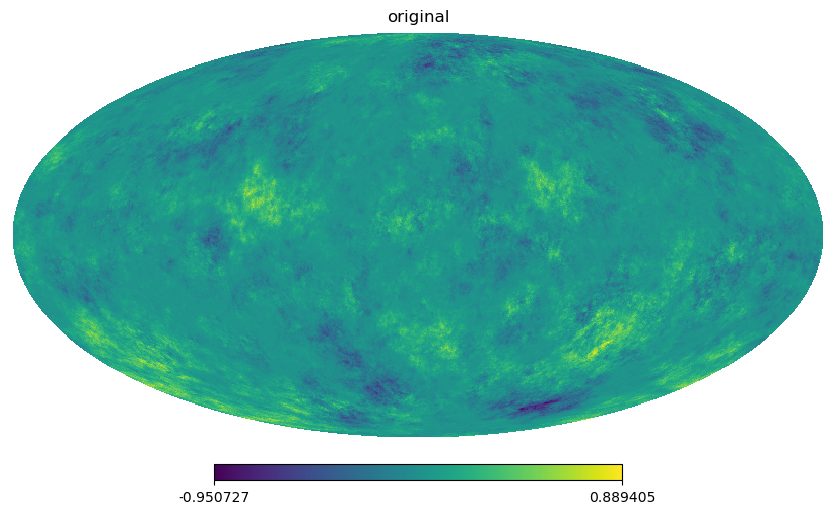

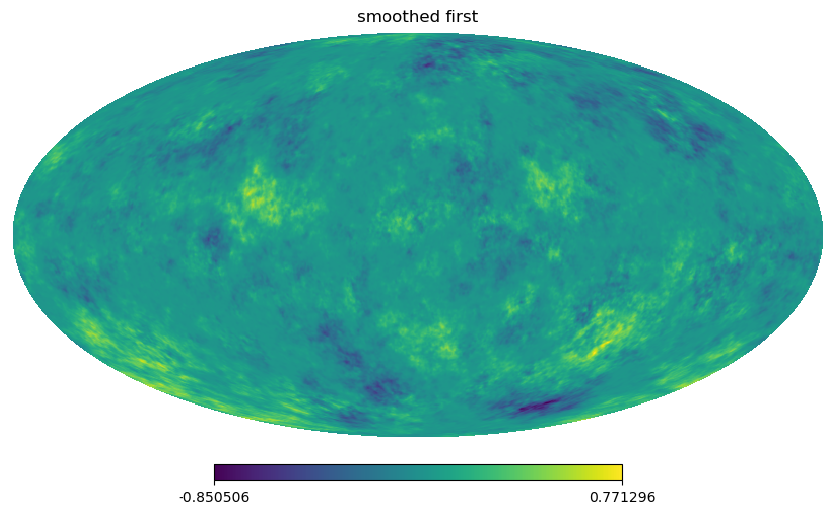

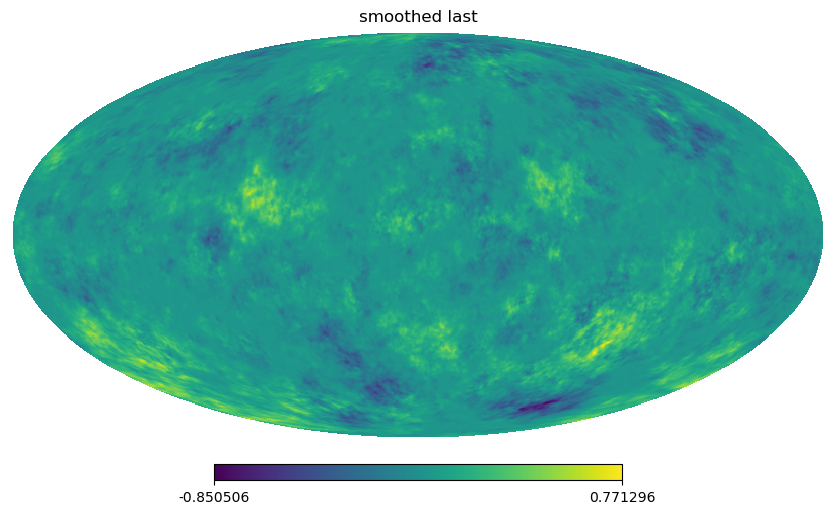

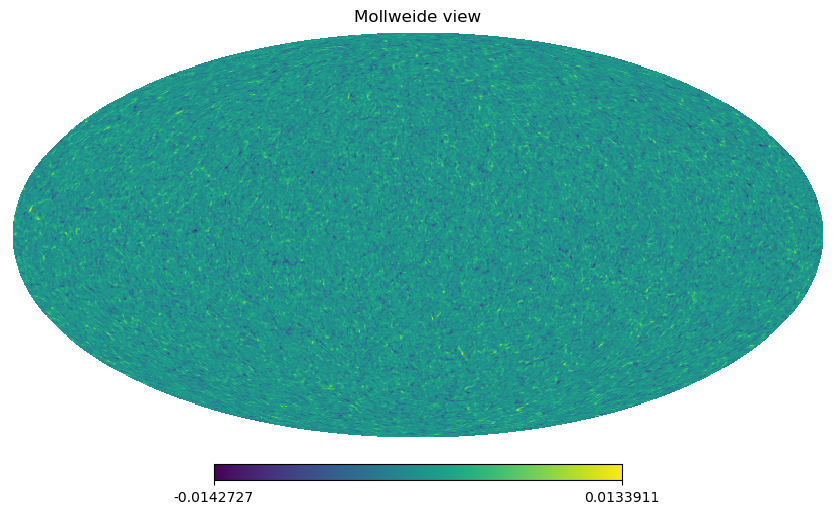

In [4]:
l_max = 300

smoothed_first = hp.smoothing(map_1, fwhm=np.pi/l_max) * hp.smoothing(map_2, fwhm=np.pi/l_max) 
smoothed_last = hp.smoothing(map_1*map_2, fwhm=np.pi/l_max)

hp.mollview(map_1*map_2, title="original")
hp.mollview(smoothed_last, title="smoothed first")
hp.mollview(smoothed_last, title="smoothed last")
hp.mollview(smoothed_first - smoothed_last)

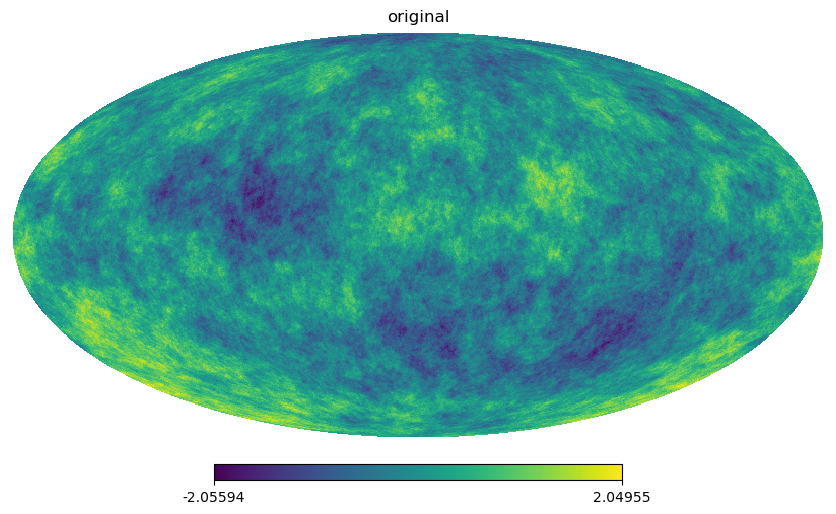

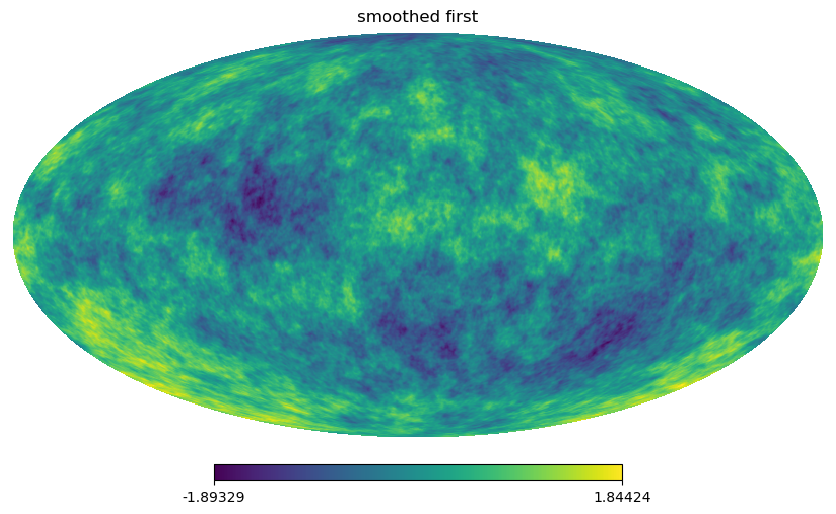

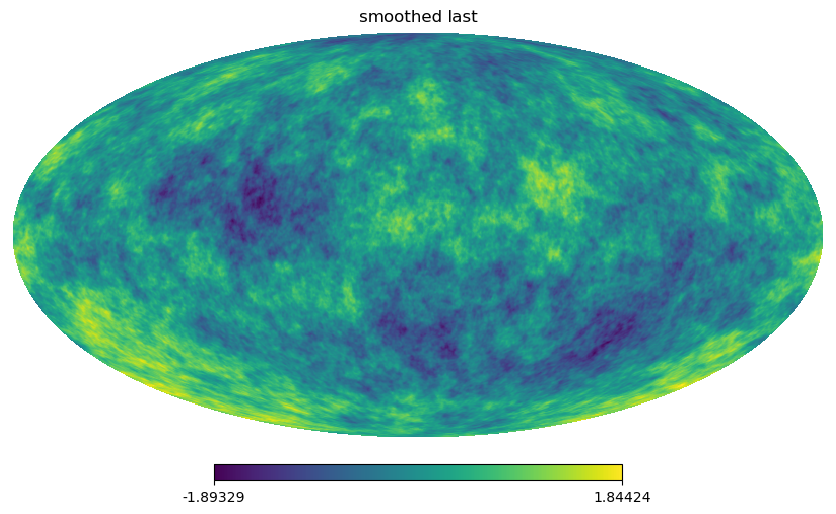

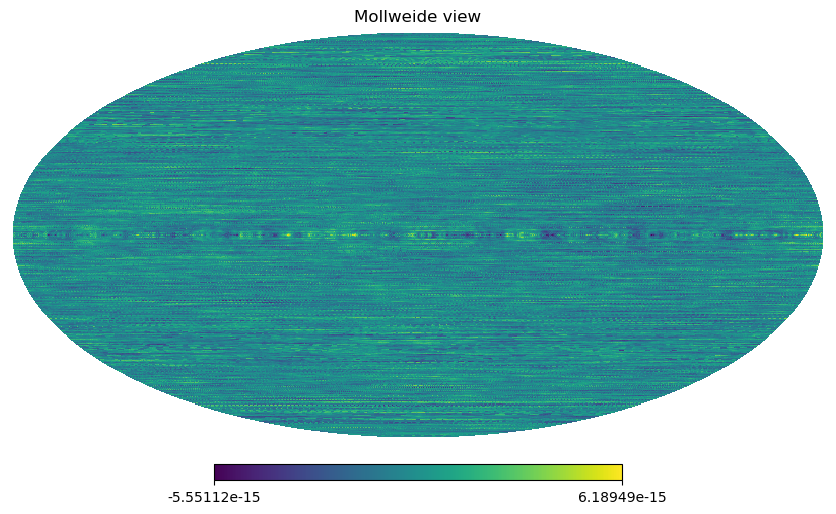

In [5]:
l_max = 300

smoothed_first = hp.smoothing(map_1, fwhm=np.pi/l_max) + hp.smoothing(map_2, fwhm=np.pi/l_max) 
smoothed_last = hp.smoothing(map_1 + map_2, fwhm=np.pi/l_max)

hp.mollview(map_1 + map_2, title="original")
hp.mollview(smoothed_last, title="smoothed first")
hp.mollview(smoothed_last, title="smoothed last")
hp.mollview(smoothed_first - smoothed_last)

# l_min and l_max

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import healpy as hp
from msfm.utils import analysis, scales, maps

23-05-11 16:37:24    scales.py INF   Setting up healpy to run on 10 CPUs 


In [8]:
data_vec_pix, _, _, _ = analysis.load_pixel_file()
n_side = 512
l_min = 10
l_max = 500

23-05-11 16:37:25  analysis.py INF   Loaded the pixel file /Users/arne/git/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


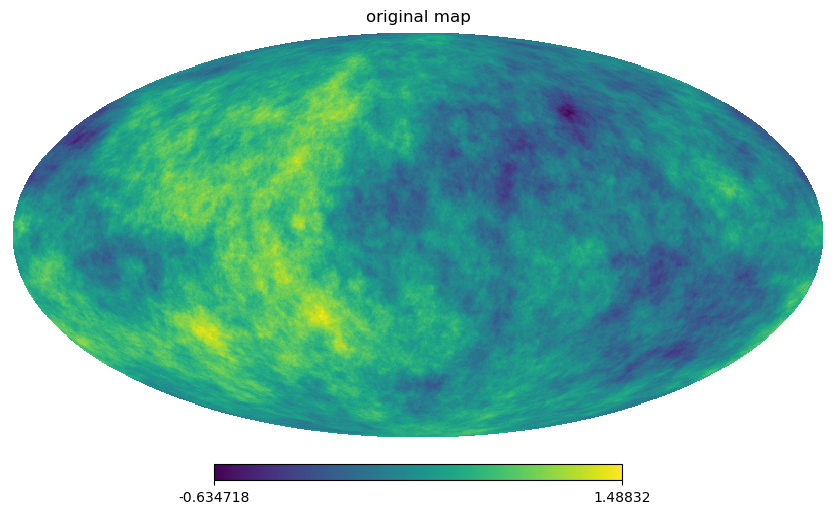

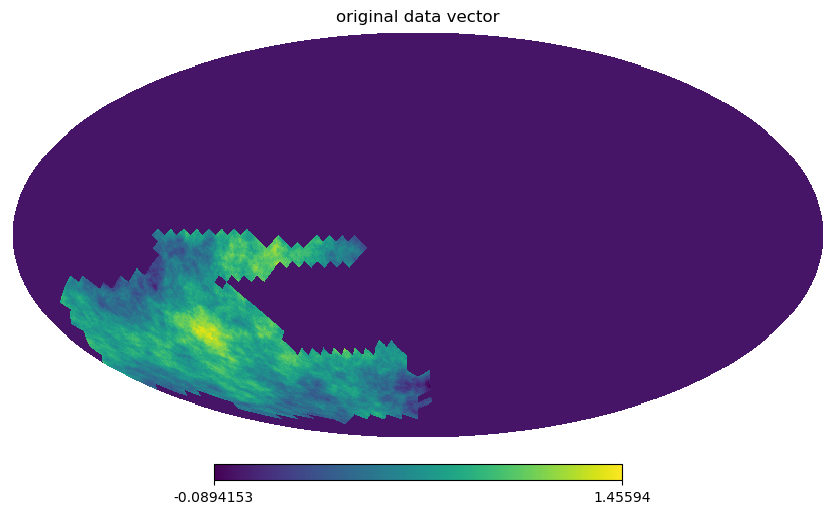

In [9]:
np.random.seed(7)
Cls = np.arange(1, 1500)**-3.
original_map = hp.synfast(cls=Cls, nside=n_side)
original_dv = hp.reorder(original_map, r2n=True)[data_vec_pix]

hp.mollview(original_map, title="original map")

hp_map = np.zeros(hp.nside2npix(n_side))
hp_map[data_vec_pix] = original_dv
hp.mollview(hp_map, title="original data vector", nest=True)

In [10]:
many_original_maps = np.stack([original_map]*100, axis=0)

In [11]:
%%timeit
hp.reorder(many_original_maps, n2r=True)

4.35 s ± 75.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
for i in range(many_original_maps.shape[0]):
    hp.reorder(many_original_maps[i], n2r=True)

4.05 s ± 55.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
hp.reorder(original_map, n2r=True)

39.7 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
maps = np.stack([original_map]*15, axis=0)

maps = hp.reorder(maps, r2n=True)

In [15]:
%%timeit
smoothed_dv = scales.data_vector_to_smoothed_data_vector(original_dv, l_min=0, l_max=l_max, n_side=n_side, data_vec_pix=data_vec_pix, nest=True)

256 ms ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


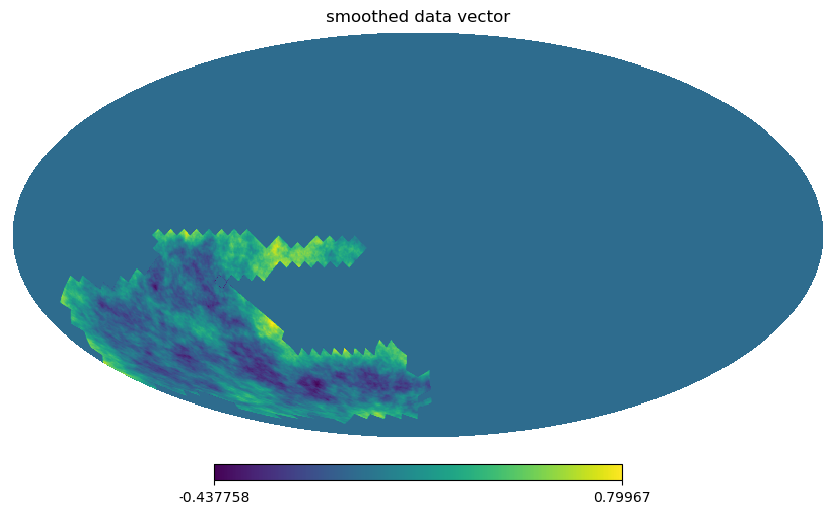

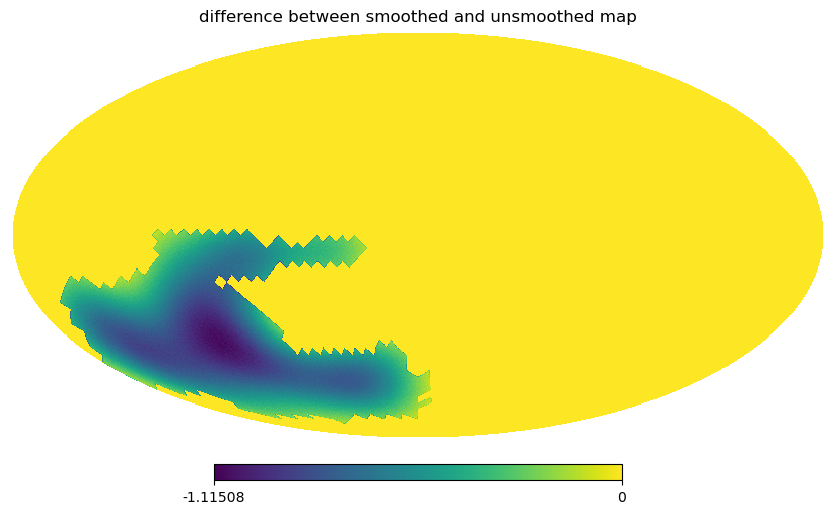

In [16]:
smoothed_dv = scales.data_vector_to_smoothed_data_vector(original_dv, l_min=l_min, l_max=l_max, n_side=n_side, data_vec_pix=data_vec_pix, nest=True)

hp_map = np.zeros(hp.nside2npix(n_side))
hp_map[data_vec_pix] = smoothed_dv
hp.mollview(hp_map, title="smoothed data vector", nest=True)


hp_map = np.zeros(hp.nside2npix(n_side))
hp_map[data_vec_pix] = smoothed_dv - original_dv
hp.mollview(hp_map, title="difference between smoothed and unsmoothed map", nest=True)

In [17]:
%%timeit

# builtin
smoothed_builtin = hp.smoothing(original_map, fwhm=np.pi/l_max, use_pixel_weights=True)

166 ms ± 8.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%timeit

# my function
smoothed_msfm = scales.map_to_smoothed_map(original_map, l_min=0, l_max=l_max, n_side=n_side, nest=False)

177 ms ± 5.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%%timeit

# my function
smoothed_msfm = scales.map_to_smoothed_map(hp.reorder(original_map, r2n=True), l_min=0, l_max=l_max, n_side=n_side, nest=True)

292 ms ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


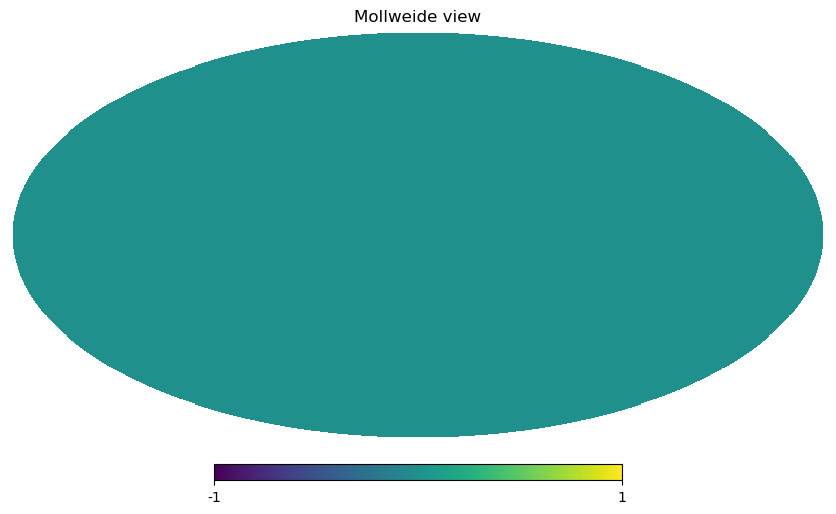

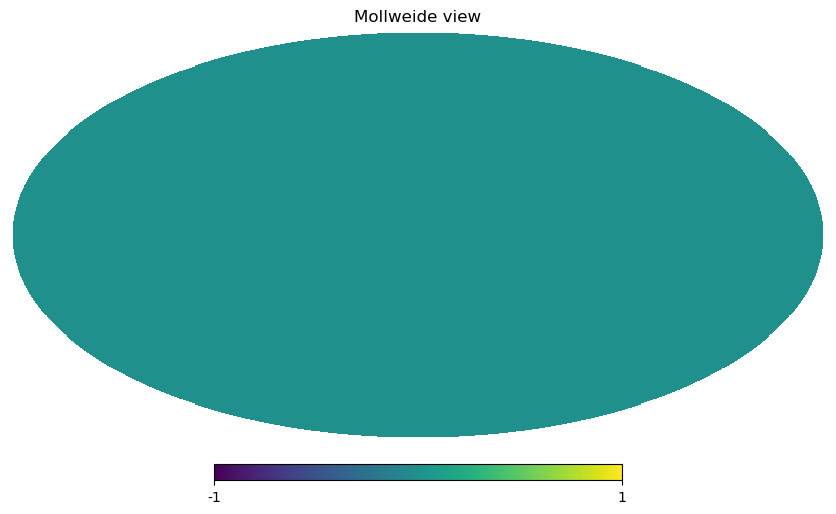

In [20]:
smoothed_builtin = hp.smoothing(original_map, fwhm=np.pi/l_max, use_pixel_weights=True)
smoothed_msfm = scales.map_to_smoothed_map(original_map, l_min=0, l_max=l_max, n_side=n_side, nest=False)
smoothed_nest = scales.map_to_smoothed_map(hp.reorder(original_map, r2n=True), l_min=0, l_max=l_max, n_side=n_side, nest=True)

hp.mollview(smoothed_builtin - smoothed_msfm)
hp.mollview(smoothed_msfm - hp.reorder(smoothed_nest, n2r=True))

# vary l_max (before smoothing)

In [21]:
# %%timeit
smoothed_full_alm = hp.smoothing(map_1, fwhm=np.pi/l_max)

In [22]:
# %%timeit
smoothed_reduced_alm = hp.smoothing(map_1, fwhm=np.pi/l_max, lmax=700)

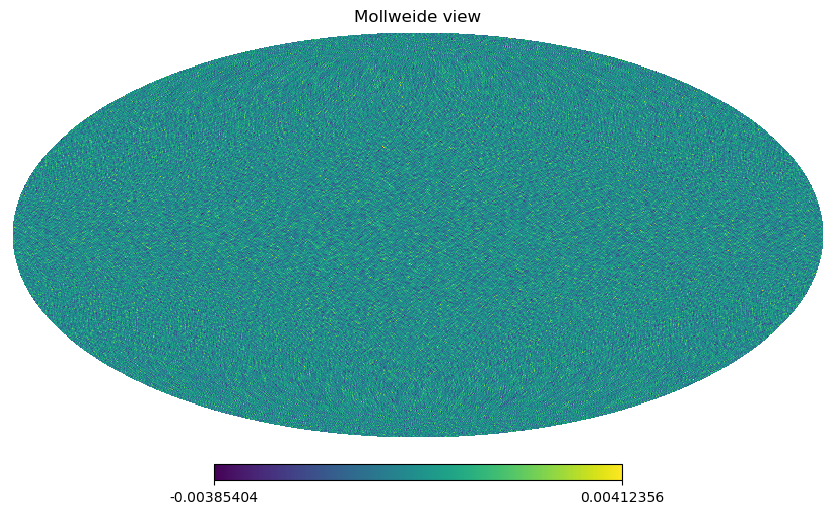

In [23]:
hp.mollview(smoothed_full_alm - smoothed_reduced_alm)